In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import statsmodels
import patsy
import pystan
import matplotlib.pylab as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = statsmodels.datasets.get_rdataset(package='survival', dataname='flchain' )
d = dataset.data.query('futime > 7').sample(500)
d.reset_index(level=0, inplace=True)
d.rename(columns={'futime': 't', 'death': 'event'}, inplace=True)

In [3]:
d.head()

,index,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,t,event,chapter
0,5550,56,M,2000,1.450,1.750,7,1.2,0,3120,0,NaN
1,1518,74,F,1997,2.190,2.100,9,1.0,0,1110,1,Neoplasms
2,2561,68,M,1996,1.340,1.430,5,NaN,0,4816,0,NaN
3,5858,57,M,1998,0.594,0.397,1,1.4,0,4018,0,NaN
4,4614,61,F,1998,0.828,1.210,2,0.9,0,3877,0,NaN


In [4]:
y, x_df = patsy.dmatrices("event ~ age + sex", d, return_type='dataframe')
x_df = x_df.iloc[:, x_df.columns != 'Intercept']

In [5]:
N, M = x_df.shape
x = x_df.as_matrix()
y = d['t'].values
event = d['event'].values.astype(int)

https://github.com/hammerlab/survivalstan/blob/master/survivalstan/stan/weibull_survival_model.stan

In [6]:
datadict = dict(N=N, M=M, x=x, y=y, event=event)
stan_m = """
functions {
  vector sqrt_vec(vector x) {
    vector[dims(x)[1]] res;

    for (m in 1:dims(x)[1]){
      res[m] = sqrt(x[m]);
    }

    return res;
  }

  vector bg_prior_lp(real r_global, vector r_local) {
    r_global ~ normal(0.0, 10.0);
    r_local ~ inv_chi_square(1.0);

    return r_global * sqrt_vec(r_local);
  }
}
data {
  // dimensions
  int<lower=0> N;             // number of observations
  int<lower=1> M;             // number of predictors
  
  // observations
  matrix[N, M] x;             // predictors for observation n
  vector[N] y;                // time for observation n
  vector[N] event;            // event status (1:event, 0:censor) for obs n
}
transformed data {
  real<lower=0> tau_mu;
  real<lower=0> tau_al;
  tau_mu = 10.0;
  tau_al = 10.0;
}
parameters {
  real<lower=0> tau_s_raw;
  vector<lower=0>[M] tau_raw;

  real alpha_raw;
  vector[M] beta_raw;

  real mu;
}

transformed parameters {
  vector[M] beta;
  real<lower=0> alpha;
  vector[N] lp;

  beta = bg_prior_lp(tau_s_raw, tau_raw) .* beta_raw;
  alpha = exp(tau_al * alpha_raw);
  for (n in 1:N) {
    lp[n] = mu + dot_product(x[n], beta);
  }
}
model {
  // priors
  beta_raw ~ normal(0.0, 1.0);
  alpha_raw ~ normal(0.0, 0.1);
  mu ~ normal(0.0, tau_mu);

  // likelihood
  for (n in 1:N) {
      if (event[n]==1)
          y[n] ~ weibull(alpha, exp(-(lp[n])/alpha));
      else
          target += weibull_lccdf(y[n] | alpha, exp(-(lp[n])/alpha));
  }
}
"""

tr_stan = pystan.stan(model_code=stan_m, data=datadict,
                      iter=2000, warmup=1000, 
                      chains=4, n_jobs=4, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_047c306154be79b16e501c30c9ec8697 NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpvmfte1e4/stanfit4anon_model_047c306154be79b16e501c30c9ec8697_6961532663874441072.cpp:599:
/home/laoj/.local/lib/python3.5/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /usr/local/lib/python3.5/dist-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/multi_array/base.hpp:28:0,
                 fro

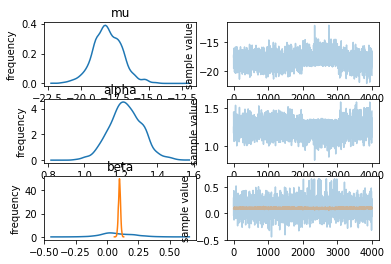

In [7]:
tr_stan.plot(pars=['mu','alpha', 'beta']);

In [13]:
sampler_params = tr_stan.get_sampler_params(inc_warmup=False)
divergent = [x for y in sampler_params for x in y['divergent__']]
n = sum(divergent)
N = len(divergent)
print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
        100 * n / N))

491.0 of 4000 iterations ended with a divergence (12.275%)


In [8]:
mu_stan = tr_stan.extract(permuted=True)['mu'].mean(axis=0)
alpha_stan = tr_stan.extract(permuted=True)['alpha'].mean(axis=0)
beta_stan = tr_stan.extract(permuted=True)['beta'].mean(axis=0)

In [9]:
sd_mu = 10.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    beta_raw = pm.Normal('b0', mu=0., sd=1., shape=M)
    alpha_raw = pm.Normal('a0', mu=0., sd=.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    tau_s_raw = pm.HalfNormal('tau_s_raw', 10.)
    tau_raw = pm.ChiSquared('tau_raw', 1., shape=M)
    beta = pm.Deterministic('beta', tau_s_raw * tt.sqrt(1. / tau_raw) * beta_raw)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))

    lp = mu + tt.dot(x, beta)

    y1 = pm.Weibull(
        'y1', alpha, tt.exp(-(lp[event == 1]) / alpha), observed=y[event == 1])
    y0 = pm.Potential(
        'y0', weibull_lccdf(y[event == 0], alpha,
                            tt.exp(-(lp[event == 0]) / alpha)))

In [10]:
with weibull:
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_raw_log__, tau_s_raw_log__, mu, a0, b0]
INFO:pymc3:NUTS: [tau_raw_log__, tau_s_raw_log__, mu, a0, b0]
100%|██████████| 2000/2000 [02:57<00:00, 11.26it/s]
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6882068055028558, but should be close to 0.8. Try to increase the number of tuning steps.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.

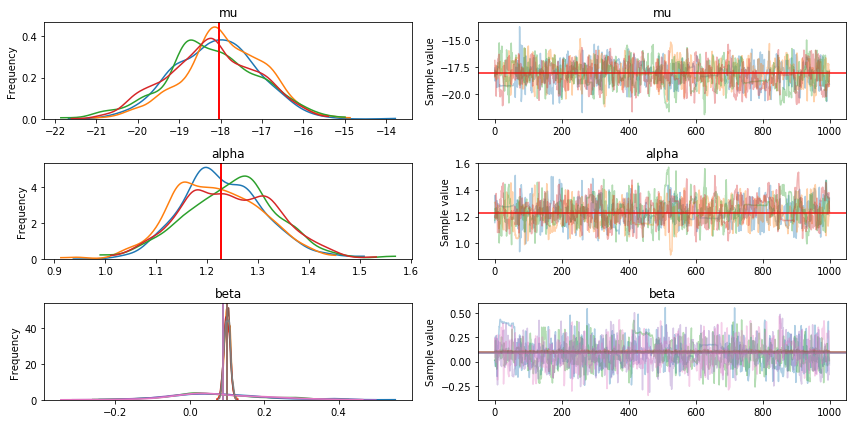

In [11]:
pm.traceplot(trace, 
             varnames=['mu','alpha', 'beta'], 
             lines=dict(mu=mu_stan, alpha=alpha_stan, beta=beta_stan));

[Weibull Survival Regression](https://discourse.pymc.io/t/weibull-survival-regression-aft/1107/3)

```
time <-c(59, 115, 156, 421, 431, 448, 464, 475, 477, 563, 638, 744, 769, 770, 803, 855, 1040, 1106, 1129, 1206, 1227, 268, 329, 353, 365, 377)
event <- c(1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0)
library(survival)
r <- survreg(Surv(time, event) ~ 1, dist="weibull")
beta <- 1/r$scale
eta <- exp(r$coefficients[1])

> beta
[1] 1.10806
> eta
(Intercept) 
   1225.419 
```

In [2]:
time = np.asarray([59, 115, 156, 421, 431, 448, 464, 475, 477, 563, 638, 744,
                   769, 770, 803, 855, 1040, 1106, 1129, 1206, 1227, 268, 329, 353, 365, 377], dtype=np.float64)
event = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
                    0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [3]:
sd_mu = 100.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    alpha_raw = pm.Normal('a0', mu=0., sd=.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))
    y1 = pm.Weibull(
        'y1', alpha, beta, observed=time[event == 1])
    y0 = pm.Potential(
        'y0', weibull_lccdf(time[event == 0], alpha, beta))
    
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, a0]
INFO:pymc3:NUTS: [mu, a0]
100%|██████████| 2000/2000 [00:08<00:00, 244.21it/s]
The acceptance probability does not match the target. It is 0.8965086413218003, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


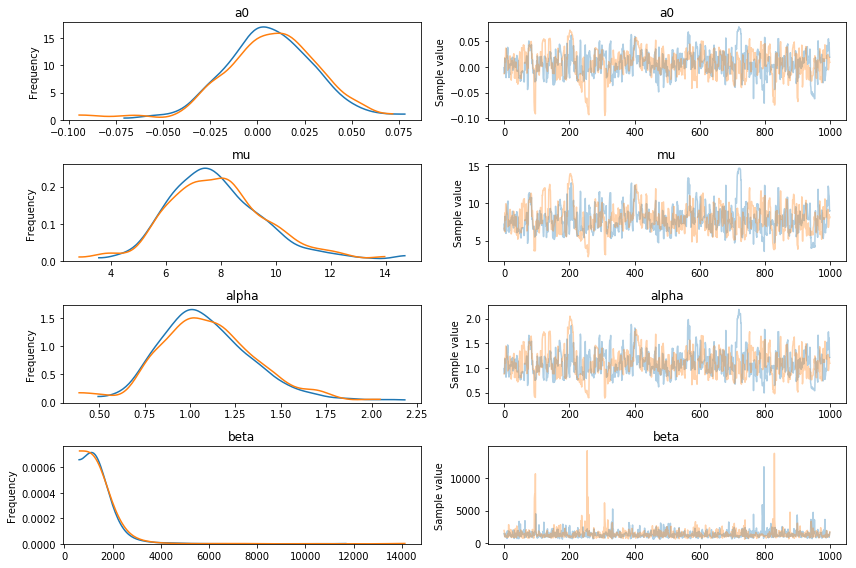

In [4]:
pm.traceplot(trace);

In [5]:
df = pm.summary(trace)
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,0.006509,0.025436,0.001358,-0.040680,0.056535,284.349583,0.999516
mu,7.890275,1.836067,0.097117,4.688151,12.064883,276.568208,0.999511
alpha,1.101429,0.275542,0.014577,0.643989,1.732503,275.726261,0.999527
beta,1448.422063,784.130800,28.120796,676.280484,2465.327196,715.322433,0.999714


https://github.com/stan-dev/example-models/blob/master/bugs_examples/vol1/kidney/kidney.stan

In [16]:
with pm.Model() as m:
    alpha = pm.Normal('alpha', 0., 10.)
    r = pm.Gamma('r', 1., .001, testval=.25)
    beta = pm.Deterministic('beta', tt.exp(-alpha / r))
    y1 = pm.Weibull(
        'y1', r, beta, observed=time[event == 1])
    y0 = pm.Bernoulli(
        'y0', tt.exp(-tt.pow(time[event == 0] / beta, r)),
         observed=np.ones(np.sum(event == 0)))

In [17]:
for var in m.basic_RVs:
    print(var.name, var.logp(m.test_point))

alpha -3.2215236261987186
r_log__ -8.294299640102027
y1 -118.12923796422496
y0 -73.75103703376016


In [18]:
with m:
    tr = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_log__, alpha]
INFO:pymc3:NUTS: [r_log__, alpha]
100%|██████████| 2000/2000 [00:07<00:00, 277.30it/s]
The acceptance probability does not match the target. It is 0.9059863930632966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


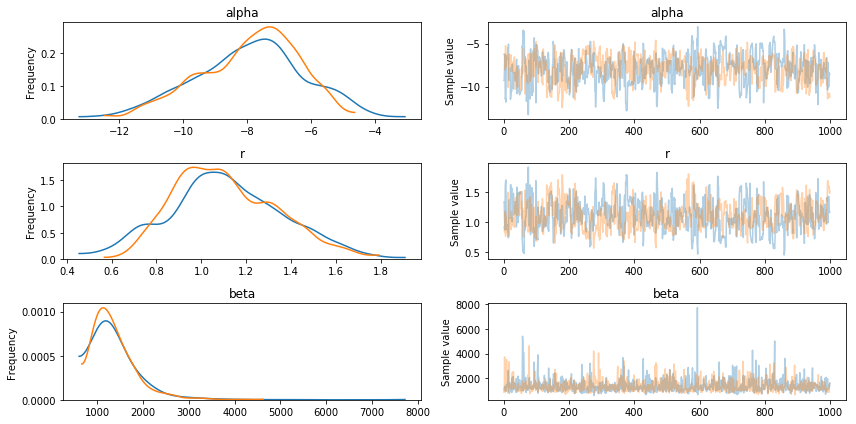

In [19]:
pm.traceplot(tr);

In [20]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-7.935054,1.639133,0.080694,-11.384194,-5.123939,272.170131,0.999504
r,1.108981,0.243460,0.011868,0.681007,1.614484,271.415337,0.999500
beta,1389.358918,522.979546,13.244010,662.450129,2296.555204,1302.923620,0.999982
